In [ ]:
%pip install sklearn-pandas

#"color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique()))"

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy
from matplotlib.cm import CMRmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
#df=pd.read_csv("ks-projects-201801.csv")
x_train_base=pd.read_csv("./data/preprocess-base-x-train.csv")
y_train_base=pd.read_csv("./data/preprocess-base-y-train.csv")
x_valid_base=pd.read_csv("./data/preprocess-base-x-valid.csv")
y_valid_base=pd.read_csv("./data/preprocess-base-y-valid.csv")

#basic_name data
#x_test_basic_name=pd.read_csv("./data/preprocess-basic_name-x-test-correct.csv")
x_train_basic_name=pd.read_csv("./data/preprocess-basic_name-x-train-correct.csv").rename(columns={"launched_month_deadline_month_0": "launched_month", "launched_month_deadline_month_1": "deadline_month"}).drop(columns=['Unnamed: 0.1'])
y_train_basic_name=pd.read_csv("./data/preprocess-basic_name-y-train-correct.csv").rename(columns={'1':'success'})
x_valid_basic_name=pd.read_csv("./data/preprocess-basic_name-x-valid-correct.csv").rename(columns={"launched_month_deadline_month_0": "launched_month", "launched_month_deadline_month_1": "deadline_month"}).drop(columns=['Unnamed: 0.1'])
y_valid_basic_name=pd.read_csv("./data/preprocess-basic_name-y-valid-correct.csv").rename(columns={'1':'success'})

#doc2vec data
#x_test_doc2vec=pd.read_csv("./data/preprocess-doc2vec-x-test.csv")
x_train_doc2vec=pd.read_csv("./data/preprocess-doc2vec-x-train.csv")
y_train_doc2vec=pd.read_csv("./data/preprocess-doc2vec-y-train.csv")
x_valid_doc2vec=pd.read_csv("./data/preprocess-doc2vec-x-valid.csv")
y_valid_doc2vec=pd.read_csv("./data/preprocess-doc2vec-y-valid.csv")


In [4]:

def one_hot_df(df,one_hot_cols,drop_cols):
    dfret=deepcopy(df)
    #dfret.astype({'launched_month': 'int32'})
    dfret=pd.get_dummies(dfret,columns=one_hot_cols).drop(columns=drop_cols)
    return dfret


def cast_to_nparray(dataset,one_hot_cols,drop_cols):
    dataset['x_train']=one_hot_df(dataset['x_train'], one_hot_cols,drop_cols)
    dataset['x_valid']=one_hot_df(dataset['x_valid'],one_hot_cols,drop_cols)
    #x_test=one_hot_df(x_test,one_hot_cols,drop_cols)
    
    dataset['x_train']=np.array(dataset['x_train'])
    dataset['x_valid']=np.array(dataset['x_valid'])
    #x_test=np.array(x_test)
    
    dataset['y_train']=np.array(dataset['y_train']['success'])
    dataset['y_valid']=np.array(dataset['y_valid']['success'])
    return dataset


In [5]:
def report_results(model, X, y):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return [result, pred, model.feature_importances_]

In [6]:
datasets={}
#'x_test':x_test_base,
datasets['base']={ 'x_train': x_train_base,'y_train':y_train_base,'x_valid':x_valid_base,'y_valid':y_valid_base}
#'x_test':x_test_basic_name,
datasets['basic_name']={'x_train': x_train_basic_name,'y_train':y_train_basic_name,'x_valid':x_valid_basic_name,'y_valid':y_valid_basic_name}
#'x_test':x_test_doc2vec,
datasets['doc2vec']={ 'x_train': x_train_doc2vec,'y_train':y_train_doc2vec,'x_valid':x_valid_doc2vec,'y_valid':y_valid_doc2vec}


dataset_keys=['base','basic_name','doc2vec']
one_hot_cols=['main_category','category','launched_month','deadline_month']
drop_cols=['Unnamed: 0']

for key in dataset_keys:
    datasets[key]=cast_to_nparray(datasets[key], one_hot_cols, drop_cols)

max_depths=[1,2,3]

x=1
num_estimators=[1]
for i in range(10):
    x*=2
    num_estimators+=[x]
    
print(num_estimators)

data = np.full((len(datasets),len(num_estimators)), 'e').tolist()


[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


In [7]:
best_model_params=[0,0,0]
data = np.full((len(datasets),len(num_estimators)), 'e').tolist()
for i in range(len(dataset_keys)):
    max_acc=0
    for j in range(len(num_estimators)):
        model=RandomForestClassifier(n_estimators=num_estimators[j], random_state=42, max_depth=None, n_jobs=-1)
        model.fit(datasets[dataset_keys[i]]['x_train'],datasets[dataset_keys[i]]['y_train'])
        res=report_results(model,datasets[dataset_keys[i]]['x_valid'],datasets[dataset_keys[i]]['y_valid'])
        if res[0]['acc']>max_acc:
            max_acc=res[0]['acc']
            best_model_params[i]=[j]
        data[i][j]=res
        dbfile = open('data_RFC', 'wb')
        pickle.dump(data, dbfile)                      
        dbfile.close()
        print("%2d,%2d" % (i,j))

 0, 0
 0, 1
 0, 2
 0, 3
 0, 4
 0, 5
 0, 6
 0, 7
 0, 8
 0, 9
 0,10
 1, 0
 1, 1
 1, 2
 1, 3
 1, 4
 1, 5
 1, 6
 1, 7
 1, 8
 1, 9
 1,10
 2, 0
 2, 1
 2, 2
 2, 3
 2, 4
 2, 5
 2, 6
 2, 7
 2, 8
 2, 9
 2,10


In [36]:

#result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
plotResults={'f1': [], 'acc': [], 'precision': [], 'recall': [], 'labels': labels}
for i in range(len(results)):
    plotResults['f1'].append(results[i]['f1'])
    plotResults['acc'].append(results[i]['acc'])
    plotResults['precision'].append(results[i]['precision'])
    plotResults['recall'].append(results[i]['recall'])
#return result, model

In [45]:
dbfile = open('results_RFC', 'wb') 

# source, destination 
pickle.dump(results, dbfile)                      
dbfile.close() 

dbfile = open('models_RFC', 'wb') 

# source, destination 
pickle.dump(models, dbfile)                      
dbfile.close() 

MemoryError: 

In [ ]:
accuracies=[]
for i in range(len(dataset_keys)):
    accs=[]
    for j in range(len(num_estimators)):
        accs.append(data[i][j][0]['acc'])
    accuracies.append(accs)
    

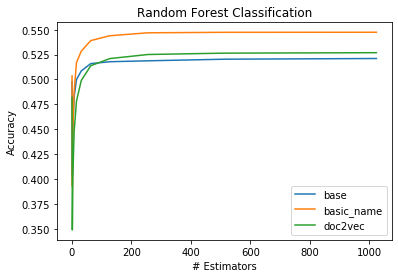

In [14]:
fig=plt.figure()
for i in range(len(accuracies)):
    plt.plot(num_estimators,accuracies[i],label=dataset_keys[i])
plt.legend()
plt.title('Random Forest Classification')
plt.ylabel('Accuracy')
plt.xlabel('# Estimators')
#plt.xlim(.639,.641)
plt.show()

In [24]:
models=[0,0,0]
for i in range(len(dataset_keys)):
    best_model=0
    best=0
    for j in range(len(num_estimators)):
        if best<data[i][j][0]['acc']:
            best_model=[i,j]
    models[i]=best_model
print(models)

[[0, 10], [1, 10], [2, 10]]


In [6]:
one_hot_cols=['main_category','category','launched_month','deadline_month']
drop_cols=['Unnamed: 0']

def cast_test_to_array(df,one_hot_cols,drop_cols):
    return np.array(pd.get_dummies(df,columns=one_hot_cols).drop(columns=drop_cols))

x_full_train_base=cast_test_to_array(x_train_base.append(x_valid_base),one_hot_cols,drop_cols)
x_full_train_basic=cast_test_to_array(x_train_basic_name.append(x_valid_basic_name),one_hot_cols,drop_cols)
x_full_train_doc2vec=cast_test_to_array(x_train_doc2vec.append(x_valid_doc2vec),one_hot_cols,drop_cols)
y_full_train=np.array(y_train_base.append(y_valid_base)['success'])

y_test=np.array(pd.read_csv("./data/preprocess-base-y-test.csv")['success'])
x_test_base=cast_test_to_array(pd.read_csv("./data/preprocess-base-x-test.csv"),one_hot_cols,drop_cols)
x_test_basic_name=cast_test_to_array(pd.read_csv("./data/preprocess-basic_name-x-test-correct.csv").rename(columns={"launched_month_deadline_month_0": "launched_month", "launched_month_deadline_month_1": "deadline_month"}).drop(columns=['Unnamed: 0.1']),one_hot_cols,drop_cols)
x_test_doc2vec=cast_test_to_array(pd.read_csv("./data/preprocess-doc2vec-x-test.csv"),one_hot_cols,drop_cols)


In [10]:
x=1
num_estimators=[1]
for i in range(10):
    x*=2
    num_estimators+=[x]
    
res=[]
trains=[x_full_train_base,x_full_train_basic,x_full_train_doc2vec]
tests=[x_test_base,x_test_basic_name,x_test_doc2vec]
for i in range(len(trains)):
    model=RandomForestClassifier(n_estimators=num_estimators[10], random_state=42, max_depth=None, n_jobs=-1)
    model.fit(trains[i],y_full_train)
    res.append(report_results(model,tests[i],y_test))

In [12]:
print(res[0][0]['acc'])
print(res[1][0]['acc'])
print(res[2][0]['acc'])

0.6409702641630172
0.6748255244265803
0.6798448217249585


In [15]:
print(len(num_estimators),len(res))
for i in [0,1,2]:
    dbfile = open('./Curry_Figs/RFC_Pred'+str(i), 'wb')
    pickle.dump(res[i][1], dbfile)                      
    dbfile.close()

11 3


In [29]:
model_base=RandomForestClassifier(n_estimators=num_estimators[10], random_state=42, max_depth=None, n_jobs=-1)
model_base.fit(x_full_train_base,y_full_train)
print(1)
model_basic=RandomForestClassifier(n_estimators=num_estimators[10], random_state=42, max_depth=None, n_jobs=-1)
model_basic.fit(x_full_train_basic,y_full_train)
print(1)
model_doc2vec=RandomForestClassifier(n_estimators=num_estimators[10], random_state=42, max_depth=None, n_jobs=-1)
model_doc2vec.fit(x_full_train_doc2vec,y_full_train)
print(1)

1


MemoryError: could not allocate 14680064 bytes

In [28]:
res_base=report_results(model_base,x_test_base,y_test)
res_basic=report_results(model_basic,x_test_basic_name,y_test)
res_doc2vec=report_results(model_doc2vec,x_test_doc2vec,y_test)
print(res_base[0]['acc'])
print(res_basic[0]['acc'])
print(res_doc2vec[0]['acc'])

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [15]:
c=0
for i in datasets[dataset_keys[i]]['y_valid']:
    if i==True:
        c+=1
print(c/len(datasets[dataset_keys[i]]['y_valid']))

c=0
for i in datasets[dataset_keys[i]]['y_train']:
    if i==True:
        c+=1
print(c/len(datasets[dataset_keys[i]]['y_train']))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


0.399199975939126
0.402446830642193


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # This is added back by InteractiveShellApp.init_path()
